# Transfer learning

You can find an example for transfer learning on [PyTorch's homepage](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). Here, we will use the same data set and architecture to make a comparison to the PyTorch homeage easier.

- [Training data](#Training-data)
- [Validation data](#Validation-data)
- [Finetuning an existing CNN](#Finetuning-an-existing-CNN)
- [Feature extraction](#Feature-extraction)
- [Exercises](#Exercises)

In [1]:
# PyTorch
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
# Pretrained networks
from torchvision.models import resnet50, resnet18
# Other packages
import matplotlib.pyplot as plt
import numpy as np
import time

## Training data

As always, we start by loading the data. Unlike the CIFAR10 dataset in notebook 2.1, there is no direct command for uploading the data, but the data is still directly available on PyTorch's homepage.

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -o -q hymenoptera_data.zip

--2024-02-19 15:13:04--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.156.46.108, 108.156.46.30, 108.156.46.129, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.156.46.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.19’

hymenoptera_data.zi 100%[===================>]  45.10M  37.8MB/s    in 1.2s    

2024-02-19 15:13:06 (37.8 MB/s) - ‘hymenoptera_data.zip.19’ saved [47286322/47286322]



Before loading the dataset into objects in Python, let's define the necessary transformations. We want to perform learning and thus need to get the images into the right format: the used neural networks expect the images to be 224x224 pixels. We also normalise the images. As we will see below, the data set is rather small. To deal with this we add data augmentation (random Rotation, random horizontal flip, random vertical flip, random resizing and random crop discussed in notebook 1.1). Data augmentation will not be needed for the testset. We will address this in the exercises.

In [3]:
means = np.array([0.485, 0.456, 0.406])
stds = np.array([0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly resize and to the model's expected input size
    transforms.RandomHorizontalFlip(), # Other augmentation
    transforms.ToTensor(),  # convert to PyTorch tensor
    transforms.Normalize(mean=means, std=stds)  # normalize images
])

In [4]:
# Load the Hymenoptera dataset
trainset = ImageFolder(root='hymenoptera_data/train', transform=train_transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
class_names = trainset.classes

Let's have a rudimentary look at the data

In [5]:
print(class_names)

['ants', 'bees']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


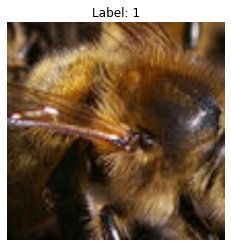

In [6]:
# Iterate over the DataLoader to get a batch of data
for batch in trainloader:
    images, labels = batch
    break  # Break after the first batch to get the first image

# Plot the first image
# Note that we multiply by stds and add means when taking data from Dataloader, since Dataload
# will apply all our transformations including the normalisation
image = torchvision.utils.make_grid(images[0]).numpy().transpose((1, 2, 0))*stds+means
plt.imshow(image)
plt.title(f"Label: {labels[0]}")
plt.axis('off')
plt.show()

In [7]:
trainset_size = len(trainset)
print(trainset_size)

244


There are only 244 images in the training set. That's too few to train your own neural network robustly from scratch. Rather than following the setup in notebook 2.1, we thus instantiate a pretrained model.

## Validation data

In addition to the training data, we need data for different testing. More specifically, we need a data set for testing *during training*, i.e. a data set that the model doesn't use for train but that is used to evaluate the performance of the model at each new epoch. This type of testing is called validation. The validation data will not be augmented, and we hence need another transform: during the validation phase, the primary concern is to evaluate the model's performance on data that you would encounter in real-world scenarios.

In [8]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(means, stds)
])

In [9]:
valset = ImageFolder(root='hymenoptera_data/val', transform=val_transform)
valloader = DataLoader(valset, batch_size=32, shuffle=True)

In [10]:
valset_size = len(valset)
print(valset_size)

153


## Finetuning an existing CNN

Let's fetch a pretrained network.

In [11]:
# Instigate the pretrained model
model1 = resnet50(pretrained=True)

# First, we need to know how many input features the last layer of the original model has
n_ftrs = model1.fc.in_features

# Then, we want to replace the last layer with a new outputlayer that has the number of features in our dataset.
n_classes = len(class_names)
model1.fc = nn.Linear(n_ftrs, n_classes)

That's it really: you have now defined your network. All you have to do now is to finetune your network to the new data set by adjusting the hyperparameters through training on the data set. To do this, you would follow (more or less) the same steps as in notebook 2.1, i.e. the code from this point on would look just as if you had made your own network from scratch. We will address this in the exercises.

## Feature extraction

Instead of finetuning the hyperparameters of the entire network, you could limit yourself to calibrating the final layer, i.e. the addition to the network. To do this you need to "freeze" the rest of the network. 

In [12]:
model2 = torchvision.models.resnet18(pretrained=True) # You could also use resnet50 as above
# Freeze the network
for param in model2.parameters():
    param.requires_grad = False

n_ftrs = model2.fc.in_features
n_classes = len(class_names)
model2.fc = nn.Linear(n_ftrs, n_classes)

Again, that's really all there is to it. Now, you have a new model. You just need to train it...

## Exercises

**Exercise 1**: Finish the code below in order to write a function for training your network. As you can see, we have added a few extra lines of code compared to the code in notebook 2.1 (e.g., on validation). Explain this code.

In [13]:
def train_model(model, loss_func, optimizer, scheduler, num_epochs=25):

    train_losses = []
    val_losses = []
    start = time.time()
    model.train()
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        model.train()  # Set model to training mode

        training_loss = 0.0
        val_loss = 0.0

        model.train()  # Set model to training mode
        # Iterate over data.
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(inputs)

            # Compute loss
            loss = # [INSERT CODE HERE]
                
            # Backward pass
            # [INSERT CODE HERE]
              
            # Optimise
            optimizer.step()

            # Update the learning rate using the scheduler
            scheduler.step()
                
            # statistics
            training_loss += loss.item() * inputs.size(0)

        epoch_train_loss = training_loss / trainset_size
        train_losses.extend([epoch_train_loss])

        # Now, we continue to validation           
        for inputs, labels in valloader:
            model.eval()   # Set model to evaluate mode
            
            # Forward pass
            y_pred = model(inputs)

            # Compute loss
            loss = loss_func(y_pred, labels)
            
            # statistics
            val_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = val_loss / valset_size
        val_losses.extend([epoch_val_loss])
        
        print(f'Training loss: {epoch_train_loss:.4f}, validation loss: {epoch_val_loss:.4f}')

    time_end = time.time() - start
    print(f'Training completed in {time_end // 60:.0f}m {time_end % 60:.0f}s')
    
    return model, train_losses, val_losses

**Exercise 2**: In the function above, we added the line "scheduler.step()". What is that good for?

To train your network, you need to define an optimiser and loss function. Let's start with model1.

In [14]:
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3, weight_decay=1e-4)

loss_func1 = # [INSERT CODE HERE]

And we have to define a scheduler (what is that?)

In [15]:
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)

You could check whether you have GPUs and then move the training there is possible.

In [16]:
# check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move to GPU
model1 = model1.to(device)

Now we can train by calling the function above. This might take some time, which is why we will limit ourselves to 5 epochs here. *You shouldn't do this if you wanted to train a proer neural network.* However, it's good enough for our puposes, and proper training might take many minutes or hours: here, we just want to illustrate and understand how neural networks work.

In [17]:
model1, train_loss1, val_loss1 = train_model(model1, loss_func1, optimizer1, scheduler1, num_epochs=5)

# Save the model
PATH = './model1_cnn.pth'
# [INSERT CODE HERE]

Epoch 0/4
Training loss: 0.6664, validation loss: 78.5393
Epoch 1/4
Training loss: 0.4869, validation loss: 1.6126
Epoch 2/4
Training loss: 0.4380, validation loss: 0.4382
Epoch 3/4
Training loss: 0.4041, validation loss: 0.3978
Epoch 4/4
Training loss: 0.3891, validation loss: 0.4037
Training completed in 3m 5s


**Exercise 3**: Plot the training and validation loss as a function of the epoch. Discuss the plot.

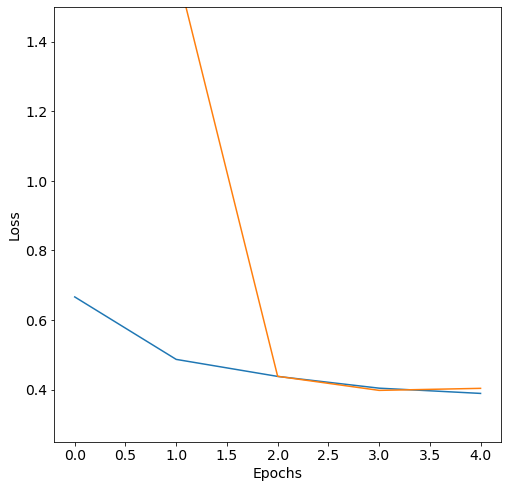

In [24]:
plt.figure(figsize=(8,8))
# [INSERT CODE HERE]
# [INSERT CODE HERE]
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.ylim([0.25,1.5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**Exercise 4**: Evaluate the accuracy of the convolutional neural network on the training and validation set. Since rerunning the training might take very long, you can just compute this measure for the final epoch, but how would you go about adding the corresponding lines of code to the training function and tracking it during training for each epoch? 

**Exercise 5**: Train model2 (the convolutional neural network as fixed feature extractor). Hint: You can use the same training function as above, but you need to define an optimiser, a loss function, and a scheduler.

**Exercise 6**: Go through the code in the example of [PyTorch's homepage](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). Highlight difference between the code in the example and the code in this notebook. Discuss these differences in the group.